## Char RNN

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [3]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [5]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# ``LongTensor`` of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample_Classifier():
    category, line = randomTrainingPair()
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor

def randomTrainingExample_Generator():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [6]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# print(categoryFromOutput(o))

## Char RNN Classifier

In [7]:
class RNNClassifier(nn.Module):
    def __init__(self,input_size,hidden_size,output_size):
        super(RNNClassifier,self).__init__()
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
        self.h2o=nn.Linear(hidden_size,output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        
    def forward(self,inp,hidden):
        hidden=self.i2h(torch.cat((inp,hidden),1))
        output=self.h2o(hidden)
        output=self.softmax(output)
        return output,hidden
        

In [8]:
n_hidden=128
rnn=RNNClassifier(n_letters,n_hidden,n_categories)

In [9]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=1e-3)

In [10]:
def train_RNNClassifier():
        hidden=torch.zeros(1,n_hidden)
        rnn.zero_grad()
        
        target,inp=randomTrainingExample_Classifier()
        for i in range(len(inp)):
            o,hidden=rnn(inp[i],hidden)
        
        loss=criterion(o,target)
        loss.backward()
        optimizer.step()
        optimizer.step()
        optimizer.zero_grad()
        return o,loss.item()
        

In [11]:
current_loss=0
all_losses=[]
for i in range(1,100001):
    o,loss=train_RNNClassifier()
    current_loss+=loss
    if i%1000==0:
        # print(categoryFromOutput(o),loss)
        avg_loss=current_loss/1000
        all_losses.append(avg_loss)
        current_loss=0


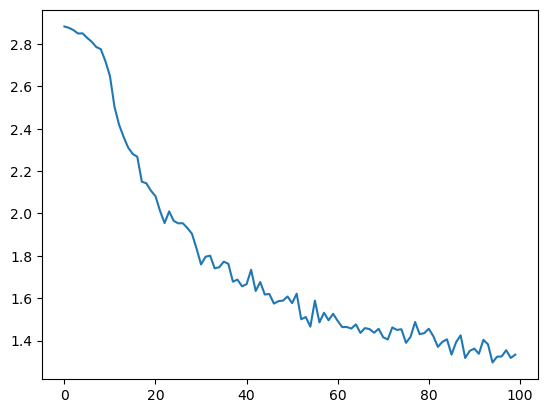

In [12]:
plt.plot(all_losses)

## Predictions

In [61]:
testnames=['Mozart','Chaikovsky','Hendrix','Beethoven','Tan','Nargiz','Su','Ahmed']
for testname in testnames:
    hidden=torch.zeros(1,n_hidden)
    inp=inputTensor(testname)
    for i in range(len(inp)):
        o,hidden=rnn(inp[i],hidden)
    print(testname,' -->',categoryFromOutput(o))

Mozart  --> ('Dutch', 15)
Chaikovsky  --> ('Russian', 6)
Hendrix  --> ('Scottish', 14)
Beethoven  --> ('Dutch', 15)
Tan  --> ('Vietnamese', 5)
Nargiz  --> ('Arabic', 2)
Su  --> ('Korean', 16)
Ahmed  --> ('Arabic', 2)


## Char RNN Generator

In [13]:
class RNNGenerator(nn.Module):
    def __init__(self,category_size,input_size,hidden_size):
        super(RNNGenerator,self).__init__()
        self.i2h=nn.Linear(category_size+input_size+hidden_size,hidden_size)
        self.h2o=nn.Linear(hidden_size,input_size)
        self.softmax=nn.LogSoftmax(dim=1)
        
        
    def forward(self,category,inp,hidden):
        hidden=self.i2h(torch.cat((category,inp,hidden),1))
        output=self.h2o(hidden)
        output=self.softmax(output)
        return output,hidden

In [14]:
hidden_size=128
category_size=18
input_size=59
hidden=torch.zeros(1,hidden_size)
rnn_generator=RNNGenerator(category_size,input_size,hidden_size)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn_generator.parameters(), lr=5e-4)

In [15]:
def train_RNNGenerator():
        tot_loss=0
        hidden=torch.zeros(1,n_hidden)
        rnn_generator.zero_grad()
        
        category_tensor, input_line_tensor, target_line_tensor=randomTrainingExample_Generator()
        for i in range(len(input_line_tensor)):
            o,hidden=rnn_generator(category_tensor,input_line_tensor[i],hidden)
            loss=criterion(o,target_line_tensor[i].unsqueeze(-1))
            # loss.backward()
            # optimizer.step()
        # Autograd Magic
        tot_loss+=loss
        tot_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        return o,tot_loss.item()
        

In [16]:
current_loss=0
all_losses=[]
for i in range(1,100001):
    o,loss=train_RNNGenerator()
    current_loss+=loss
    if i%1000==0:
        # print(categoryFromOutput(o),loss)
        avg_loss=current_loss/1000
        all_losses.append(avg_loss)
        current_loss=0

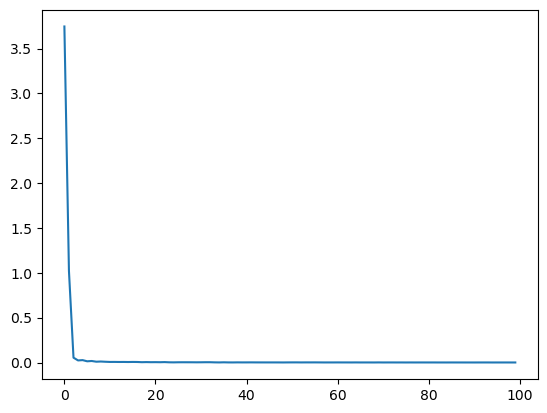

In [17]:
plt.plot(all_losses)

In [20]:
categoryTensor('German')

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
inputTensor('R')[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])

In [35]:
p=rnn_generator(categoryTensor('Chinese'),inputTensor('p')[0],torch.zeros(1,hidden_size))

In [36]:
p[0][0]

tensor([-4.2832, -4.2849, -4.3362, -4.4556, -4.2808, -4.4713, -4.2879, -4.3486,
        -4.4590, -4.3388, -4.4973, -4.3979, -4.5140, -4.3877, -4.2913, -4.3602,
        -4.2840, -4.3121, -4.3891, -4.4107, -4.5667, -4.4598, -4.3099, -4.6155,
        -4.3448, -4.3788, -4.5104, -4.4592, -4.4559, -4.4349, -4.4251, -4.4897,
        -4.2905, -4.3334, -4.5063, -4.4104, -4.2779, -4.3312, -4.2674, -4.4342,
        -4.1781, -4.3206, -4.3286, -4.3940, -4.5124, -4.3921, -4.3267, -4.2614,
        -4.5997, -4.4363, -4.5441, -4.4137, -4.3155, -4.4063, -4.3084, -4.3686,
        -4.5023, -4.3593, -1.2795], grad_fn=<SelectBackward0>)

In [37]:
torch.argmax(p[0][0])

tensor(58)

In [51]:
inputTensor('p')[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]])

In [60]:
randomTrainingExample_Generator()[2].shape

torch.Size([8])